In [1]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("JupyterSpark")
    .master("local[*]")
    .getOrCreate()
)

spark

In [2]:
import numpy as np
import pandas as pd

from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import sklearn

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Adjust column width to prevent truncation of cell content
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [3]:
mon_file = r"dnd_monsters.csv"

mon_df = (spark.read.format("csv")
            .option("header","true")
            .option("inferSchema","true")
            .load(mon_file))

#mon_df.show()

df = pd.read_csv("dnd_monsters.csv")
df.head()

,name,url,cr,type,size,ac,hp,speed,align,legendary,source,str,dex,con,int,wis,cha
0,aarakocra,https://www.aidedd.org/dnd/monstres.php?vo=aarakocra,1/4,humanoid (aarakocra),Medium,12,13,fly,neutral good,NaN,Monster Manual (BR),10.0,14.0,10.0,11.0,12.0,11.0
1,abjurer,NaN,9,humanoid (any race),Medium,12,84,NaN,any alignment,NaN,Volo's Guide to Monsters,NaN,NaN,NaN,NaN,NaN,NaN
2,aboleth,https://www.aidedd.org/dnd/monstres.php?vo=aboleth,10,aberration,Large,17,135,swim,lawful evil,Legendary,Monster Manual (SRD),21.0,9.0,15.0,18.0,15.0,18.0
3,abominable-yeti,NaN,9,monstrosity,Huge,15,137,NaN,chaotic evil,NaN,Monster Manual,NaN,NaN,NaN,NaN,NaN,NaN
4,acererak,NaN,23,undead,Medium,21,285,NaN,neutral evil,NaN,Adventures (Tomb of Annihilation),NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df["type"].value_counts()
df["speed"].value_counts()
#df["legendary"].value_counts()
#df["align"].value_counts()
#df["size"].value_counts()

speed
fly          153
swim          70
fly, swim     25
Name: count, dtype: int64

**Variables**

**name**: name the monster species

**cr**: Challenge Rating that determines how difficult it is to be defeated by a party.

**type**: classification of the monsters race: humanoid, monsterous, undead, etc.

**size**: tiny, small, medium, large, gigantic

**ac**: armor class is how difficult an enemy is to hit. Higher level party members can consistently hit a high ac class enemy.

**hp**: health points

**speed**: modes of movement fly, swim and land(default). Indicates the physical features of a monster.

**align**: The moral alignment (good, neutral, evil)x(lawful, neutral, chaotic). Unaligned monsters are not sentient and lack personalities. Any Alignment implies any personality.

**legendary**: Monsters that are uniquely powerful and challenging. It’s both a mechanical and narrative trait.

**str**: Strength

**dex**: Dexterity

**con**: Constitution (health)

**int**: Intelligence

**wis**: Wisdom

**cha**: Charisma


In [5]:
# Remove irrelevant columns
df = df.drop("url", axis=1)
df = df.drop("source", axis=1)

# cr to float
df["cr"] = df["cr"].fillna(0)
df["cr"] = df["cr"].apply(lambda x: float(eval(str(x))))  # "1/2" -> 0.5

# Simplify types. Remove parentheses and anything inside them
df["type"] = df["type"].str.replace(r"\(.*\)", "", regex=True).str.strip()
df["type"].value_counts()

# Legendary Column has 1 or 0 values
df["legendary"] = df["legendary"].replace({"Legendary": 1})
df["legendary"] = df["legendary"].fillna(0)
df["legendary"] = df["legendary"].astype(bool)

# Speed can be water, fly, or lang
df["speed"] = df["speed"].fillna("land")

# Remove rows with missing stats
df = df.dropna()

df.head()

,name,cr,type,size,ac,hp,speed,align,legendary,str,dex,con,int,wis,cha
0,aarakocra,0.25,humanoid,Medium,12,13,fly,neutral good,False,10.0,14.0,10.0,11.0,12.0,11.0
2,aboleth,10.00,aberration,Large,17,135,swim,lawful evil,True,21.0,9.0,15.0,18.0,15.0,18.0
5,acolyte,0.25,humanoid,Medium,10,9,land,any alignment,False,10.0,10.0,10.0,10.0,14.0,11.0
6,adult-black-dragon,14.00,dragon,Huge,19,195,"fly, swim",chaotic evil,True,23.0,14.0,21.0,14.0,13.0,17.0
8,adult-blue-dragon,16.00,dragon,Huge,19,225,fly,lawful evil,True,25.0,10.0,23.0,16.0,15.0,19.0


In [6]:
# Prepare align column
align_col = df["align"].str.lower().str.strip()

def get_method(align):
    if "lawful" in align:
        return "lawful"
    elif "chaotic" in align:
        return "chaotic"
    elif "neutral" in align and not "any" in align:  # neutral that is not "any ..."
        return "neutral"
    elif "any" in align:
        return "any"
    else:
        return "None"  # unaligned

df["Method"] = align_col.apply(get_method)

def get_morality(align):
    if "good" in align:
        return "good"
    elif "evil" in align:
        return "evil"
    elif "neutral" in align and not "any" in align:
        return "neutral"
    elif "any" in align:
        return "any"
    else:
        return "None"  # unaligned

df["Morality"] = align_col.apply(get_morality)


# Use the new Method and Morality columns
def get_is_aligned(align):
    if "any alignment" in align:
        return "any alignment"
    elif "unaligned" in align:
        return "unaligned"
    else: 
        return "aligned"

df["Aligned"] = align_col.apply(get_is_aligned)

df.to_csv("monsters_clean_tableau.csv", index=False)


In [7]:
df.head()

,name,cr,type,size,ac,hp,speed,align,legendary,str,dex,con,int,wis,cha,Method,Morality,Aligned
0,aarakocra,0.25,humanoid,Medium,12,13,fly,neutral good,False,10.0,14.0,10.0,11.0,12.0,11.0,neutral,good,aligned
2,aboleth,10.00,aberration,Large,17,135,swim,lawful evil,True,21.0,9.0,15.0,18.0,15.0,18.0,lawful,evil,aligned
5,acolyte,0.25,humanoid,Medium,10,9,land,any alignment,False,10.0,10.0,10.0,10.0,14.0,11.0,any,any,any alignment
6,adult-black-dragon,14.00,dragon,Huge,19,195,"fly, swim",chaotic evil,True,23.0,14.0,21.0,14.0,13.0,17.0,chaotic,evil,aligned
8,adult-blue-dragon,16.00,dragon,Huge,19,225,fly,lawful evil,True,25.0,10.0,23.0,16.0,15.0,19.0,lawful,evil,aligned


In [8]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
df.head()

,name,cr,type,size,ac,hp,speed,align,legendary,str,dex,con,int,wis,cha,Method,Morality,Aligned
0,aarakocra,0.25,humanoid,Medium,12,13,fly,neutral good,False,10.0,14.0,10.0,11.0,12.0,11.0,neutral,good,aligned
2,aboleth,10.00,aberration,Large,17,135,swim,lawful evil,True,21.0,9.0,15.0,18.0,15.0,18.0,lawful,evil,aligned
5,acolyte,0.25,humanoid,Medium,10,9,land,any alignment,False,10.0,10.0,10.0,10.0,14.0,11.0,any,any,any alignment
6,adult-black-dragon,14.00,dragon,Huge,19,195,"fly, swim",chaotic evil,True,23.0,14.0,21.0,14.0,13.0,17.0,chaotic,evil,aligned
8,adult-blue-dragon,16.00,dragon,Huge,19,225,fly,lawful evil,True,25.0,10.0,23.0,16.0,15.0,19.0,lawful,evil,aligned


**Post Interpretation Notes**

After creating PCA and KMeans models using the following predictive features, I've made the following conclusions that will help me
determine what changes to make.

features = (["cr","hp","ac","str","dex","con","int","wis","cha"])

1. The most common group appearing across PCA and KMeans are Balanced Challenging Monsters and Balanced Unchallenging Monsters.
2. Archetypes like (Brutes) High Mental-Low Physical and (Cunning) High Physical-Low Mental are prevalent across both models.
3. The Glass Cannon Archetype appears in PCA. High Strength but low health and low armor. It's an interesting archetype but this may be CR Challenge Rating manipulating the reults. 
4. Balanced-Challening, Balanced-Difficult, Balanced-Easy appear in 6 Clusters

5. The CR Challenge Rating always corresponds with HP. Removing it may reduce noise and determine more confident components and clusters. 
6. AC has some variation from its neighbooring stats.
7. INT, WIS, CHA trend together in the same direction.  
8. STR and CON trend together in the same direction.

I considered feature engineering a Mind and Body feature that combine INT, WIS, CHA and STR,CON respectivley. But the individual features are too integral to the game.

Removing CR may reduce noise. In-game the Challenge Rating of a monster does not contribute to gameplay anyway. And is something of a Principal Component itself.

**Principal Component Analysis**

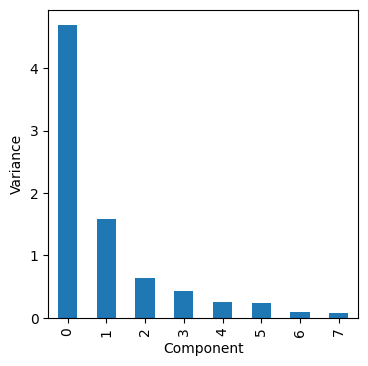

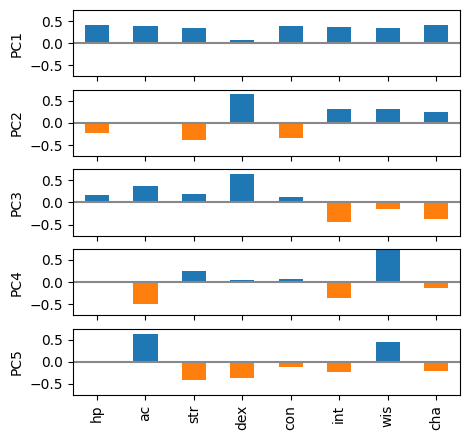

In [9]:
features = (["hp","ac","str","dex","con","int","wis","cha"])
df_con = df.loc[:, features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_con)

mon_PCA = PCA()
mon_PCA.fit(X_scaled)

explained_variance = pd.DataFrame(mon_PCA.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4,4))
ax.set_xlabel('Component')
ax.set_ylabel("Variance")

loadings = pd.DataFrame(mon_PCA.components_[0:5,:], columns = features)
maxPC = 1.01*np.max(np.max(np.abs(loadings.loc[0:5,:])))

f, axes = plt.subplots(5,1, figsize=(5,5), sharex=True)
for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l>0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color = colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)



**PCA Explanations of Variability**

PC1 45%: Balanced Monsters with low Dexterity 

PC2 15%: Physically Weak Monsters with high mental and dexterity stats.

PC3 5%: Physically Powerful Monsters with low mental stats 

PC4 5%: Weak Wisdom build Monsters

PC5 2%: Strong Wisdom build Monsters

**K-Means Clustering**

Text(0, 0.5, 'Average Within-Cluster Squared Distances')

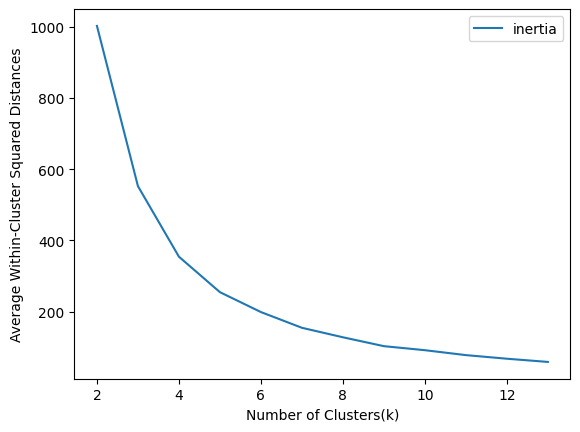

In [10]:
inertia = []
for n_clusters in range(2,14):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_scaled)
    inertia.append(kmeans.inertia_/n_clusters)

inertias = pd.DataFrame({'n_clusters': range(2,14), 'inertia':inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')

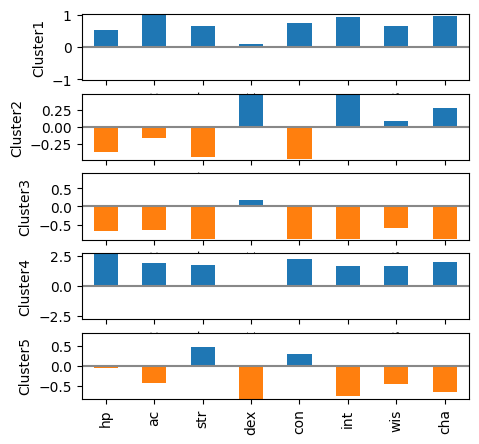

In [11]:
kmeans = KMeans(n_clusters=5, n_init=200,random_state=42).fit(X_scaled)

fig, axes = plt.subplots(5, 1, figsize=(5, 5))

centers = pd.DataFrame(kmeans.cluster_centers_, columns=features)

for i, ax in enumerate(axes):
    center = centers.loc[i,:]
    maxPC = 1.01*np.max(np.max(np.abs(center)))
    colors = ['C0' if l>0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster{i+1}')
    ax.set_ylim(-maxPC, maxPC)

plt.show()

In [13]:
centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=features,
    index=[f"Cluster {i+1}" for i in range(len(kmeans.cluster_centers_))]
)

tableau_df = (
    centers
    .reset_index(names="Cluster")
    .melt(id_vars="Cluster", var_name="Feature", value_name="Value")
)

tableau_df.to_csv("kmeans_cluster_centers_tableau.csv", index=False)

In [14]:
from collections import Counter
Counter(kmeans.labels_)

Counter({np.int32(1): 105,
         np.int32(2): 103,
         np.int32(4): 93,
         np.int32(0): 72,
         np.int32(3): 28})

**4 Clusters**

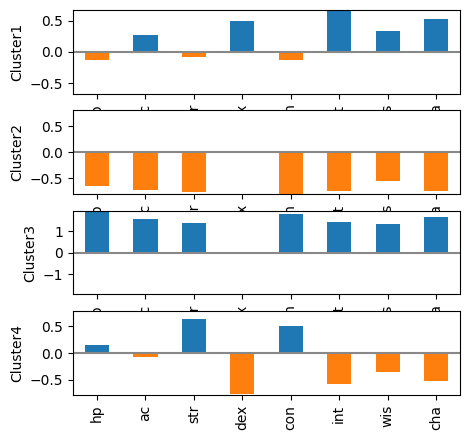

123 | Cluster 1: Monsters with high mental traits but low physical traits.

148 | Cluster 2 : Weak Creatures that rely on dexterity

 52 | Cluster 3 : Balanced Overall

 78 | Cluster 4: Monsters with high strength but low mental traits.

**5 Clusters**

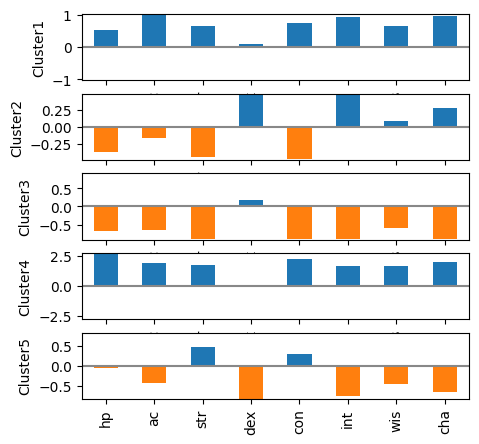

Cluster 1: Weak Creatures that fight with strength

Cluster 2: Balanced Monsters

Cluster 3: Brutes

CLuster 4: Clever

Cluster 5: Weak Creatures that fight with dexterity


**6 Clusters**

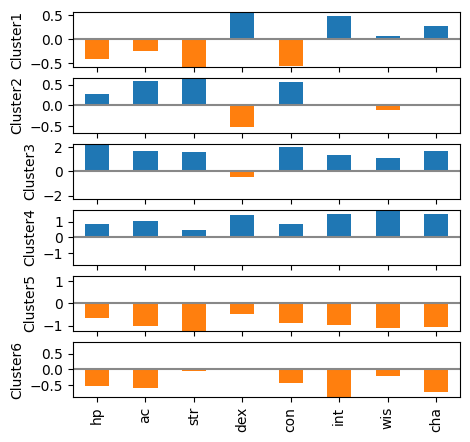

Cluster 1: Clever Monsters

Cluster 2: Brutes

Cluster 3: Challengig Balanced Monsters low dex

Cluster 4: Balanced Monsters

Cluster 5: Very Weak Monsters 

Cluster 6: Weak Monsters that rely on dexterity

**Review**

The elbow plot above reveals the ideal number of clusters to be 4-6.

4 Clusters reveals the most prominent clusters that appear in 5 and 6 clusters.
1. Balanced Monsters overall
2. Monsters that rely on mental stats rather than physical
3. Monsters that rely on physical stats rather than mental
4. Weak Monsters overall that rely on dexterity.

5 Clusters introduces a new group of monsters

5. Weak Monsters overall that rely on strength.

6 Clusters create redunant groups such as 

6. Weak and very weak
7. Strong and very strong

with no noteable attributes.

So what is the right amount of clusters to be selected?
I believe that answer should be determined by how many monsters are classified by each cluster.


In [15]:
df_con['cluster'] = kmeans.labels_
df_con.head()

df['cluster'] = kmeans.labels_
df.head()

df.to_csv('updated_monsters.csv')